In [135]:
import spimage
import time
import h5py
import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
%matplotlib inline
mpl.rcParams['image.cmap'] = 'viridis'

In [6]:
def get_indexes_range(indexes):
    min_x = np.amin(indexes)
    max_x = np.amax(indexes)
    total_range = max_x - min_x
    return min_x - total_range/10, max_x + total_range/10

def plot_3d_array(data, level=0, step=1, range_x=0, range_y=0, range_z=0):
    if level == 0:
        level = np.mean(data)
    
    verts, faces, normals, values = measure.marching_cubes_lewiner(data, level, step_size=step)
    
    fig = plt.figure(figsize=(11,4))
    ax = fig.gca(projection='3d')
    ax.set_title('3d image')
    mesh = Poly3DCollection(verts[faces],linewidths=0.2)
    ax.add_collection3d(mesh)
    
    selected_x, selected_y, selected_z = (data >= level).nonzero()
    if range_x == 0:
        range_x = get_indexes_range(selected_x)
    if range_y == 0:
        range_y = get_indexes_range(selected_y)
    if range_z == 0:
        range_z = get_indexes_range(selected_z)
    
    ax.set_xlim(*range_x)
    ax.set_ylim(*range_y)
    ax.set_zlim(*range_z)
    plt.show()
    
def shape_3d(vol):
    l = int(np.round(np.power(vol.shape[0], 1./3)))
    return vol.reshape((l, l, l))
    
def plot_2d(image, ax, norm, colorbar=True):
    im = ax.imshow(image, norm=norm)
    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
    
def plot_3d_cuts(vol, logscale=True, colorbar=True):
    if logscale:
        norm = colors.LogNorm(vmin=0.001, vmax=np.amax(vol))
    else:
        norm = colors.Normalize(vmin=np.amin(vol), vmax=np.amax(vol))

    if len(vol.shape) == 1:
        vol = shape_3d(vol)
    
    l = vol.shape[0]
    
    fig, ax = plt.subplots(1, 3, figsize=(20,10))
    
    plot_2d(vol[l//2,:,:], ax[0], norm, colorbar)
    plot_2d(vol[:,l//2,:], ax[1], norm, colorbar)
    plot_2d(vol[:,:,l//2], ax[2], norm, colorbar)
    
def plot_graph(*args,**kwargs):
    fig = plt.figure(figsize=(11,4))
    ax = fig.add_subplot(111)
    ax.plot(*args,**kwargs)
    plt.show()

def apply_binning(data, bin_value):
    Z,Y,X = data.shape

    newX = X//bin_value
    newY = Y//bin_value
    newZ = Z//bin_value

    new_data = data[:newZ*bin_value,:newY*bin_value,:newX*bin_value].reshape(newZ,bin_value,newY,bin_value,newX,bin_value).sum(axis=(1,3,5))

    return new_data

In [142]:
file_name = 'intens_11000_phased_bin2_1100iter.h5'

with h5py.File(file_name, 'r') as h5file:
    fourier_data = h5file['fourier_data'][:]
    real_data = h5file['real_data'][:]
    iter_idx = h5file['phase_ret/iteration_index_scores'][:]
    real_error = h5file['phase_ret/real_error'][:]
    fourier_error = h5file['phase_ret/fourier_error'][:]

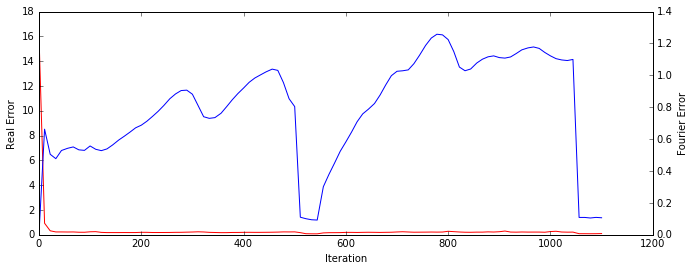

In [143]:
fig, ax1 = plt.subplots(figsize=(11,4))
ax2 = ax1.twinx()

ax1.plot(iter_idx, real_error, color='r')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Real Error')

ax2.plot(iter_idx, fourier_error, color='b')
ax2.set_ylabel('Fourier Error')
plt.show()

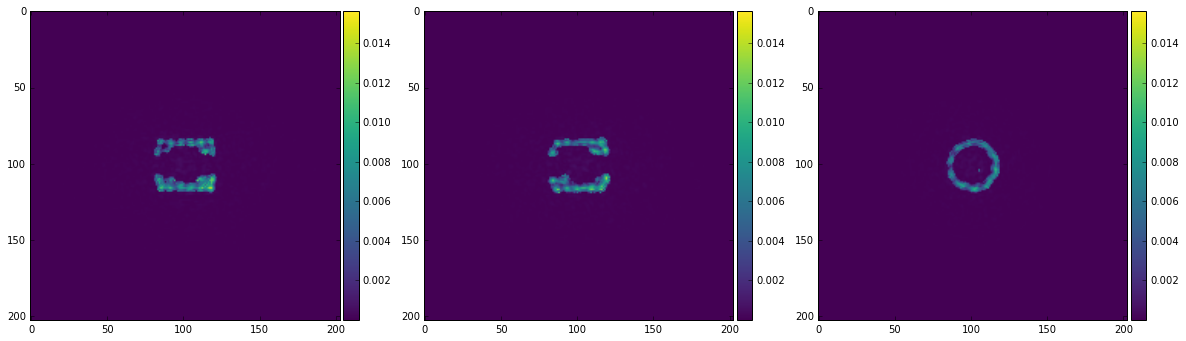

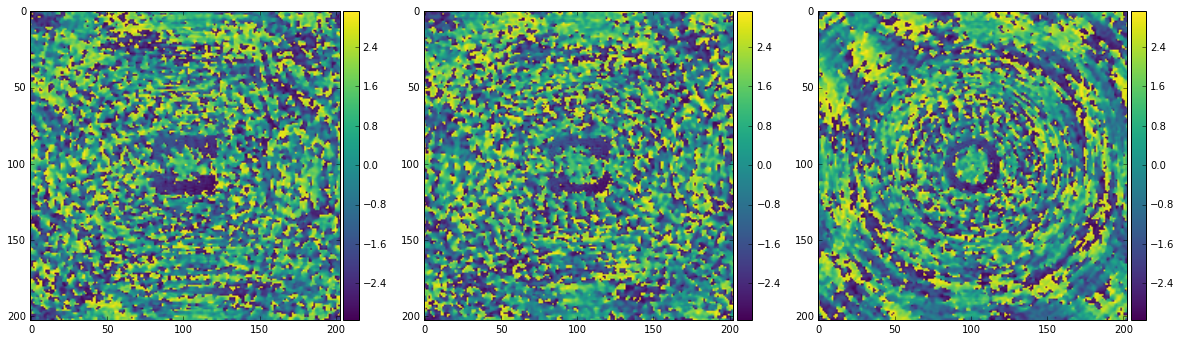

In [144]:
plot_3d_cuts(np.abs(real_data), logscale=False)
plot_3d_cuts(np.angle(real_data), logscale=False)

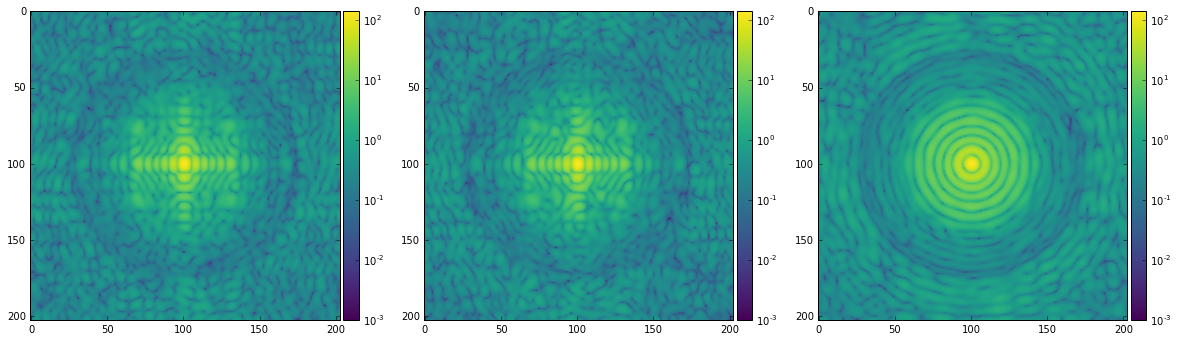

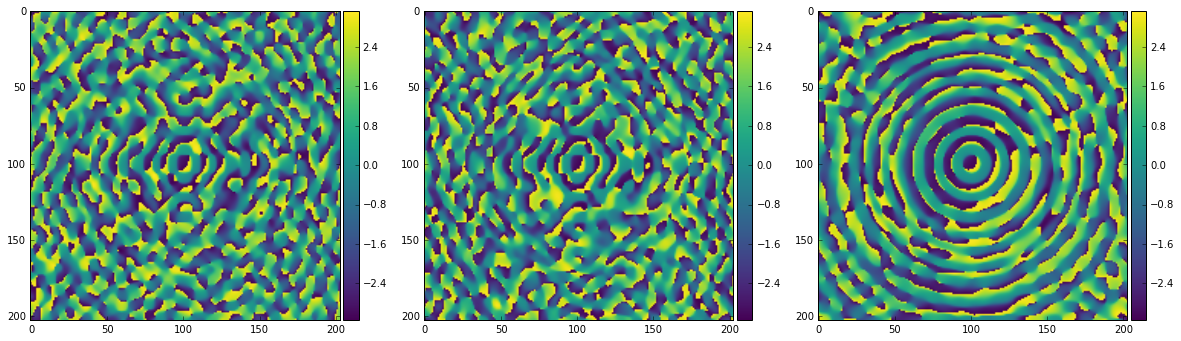

In [138]:
plot_3d_cuts(np.abs(fourier_data))
plot_3d_cuts(np.angle(fourier_data), logscale=False)

In [154]:
# Load data

with h5py.File('intens_11000_phased_bin2_1100iter.h5', 'r') as h5file:
    fourier_11k = h5file['fourier_data'][:]
    real_11k = h5file['real_data'][:]
    
with h5py.File('intens_5000_phased_bin2_1100iter.h5', 'r') as h5file:
    fourier_5k = h5file['fourier_data'][:]
    real_5k = h5file['real_data'][:]
    
with h5py.File('intens_100_phased_bin2_1100iter.h5', 'r') as h5file:
    fourier_100 = h5file['fourier_data'][:]
    real_100 = h5file['real_data'][:]
    
with h5py.File('model_phased_bin2_1100iter.h5', 'r') as h5file:
    fourier_model = h5file['fourier_data'][:]
    real_model = h5file['real_data'][:]

In [155]:
def compute_fcs(data, model, qmin, qmax):
    nz, ny, nx = data.shape
    qx = np.arange(nx) - nx//2
    qy = np.arange(ny) - ny//2
    qz = np.arange(nz) - nz//2
    
    xx, yy, zz = np.meshgrid(qx, qy, qz)
    
    qq = np.round(np.sqrt(xx*xx + yy*yy + zz*zz))
    
    fcs = []
    q_val = np.arange(qmin, qmax)
    
    for q in q_val:
        data_points = data[qq==q]
        model_points = model[qq==q]
        data_abs = np.abs(data_points)
        model_abs = np.abs(model_points)
        fcs_val = np.sum(np.multiply(data_points, np.conj(model_points)))
        fcs_val /= np.sqrt(np.sum(np.multiply(data_abs,data_abs))*np.sum(np.multiply(model_abs,model_abs)))
        fcs.append(fcs_val)
        
    return np.array(fcs), q_val
    
    
fcs_11k, q_11k = compute_fcs(fourier_11k, fourier_model, 0, fourier_model.shape[0]//2)
fcs_5k, q_5k = compute_fcs(fourier_5k, fourier_model, 0, fourier_model.shape[0]//2)
fcs_100, q_100 = compute_fcs(fourier_100, fourier_model, 0, fourier_model.shape[0]//2)

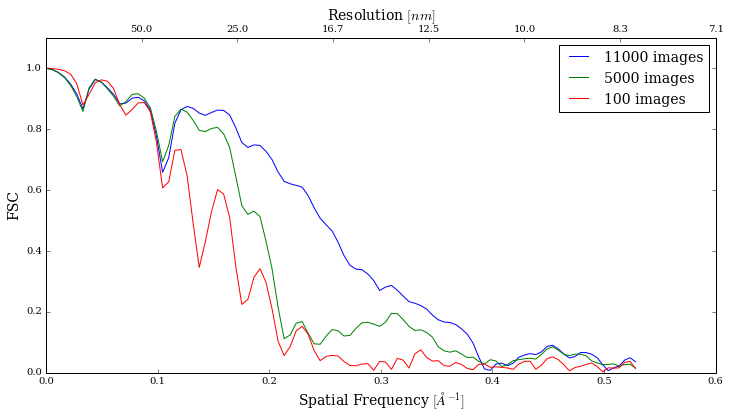

In [230]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))


ax.plot(compute_freq(q_11k*2)*10, np.abs(fcs_11k), label='11000 images')
ax.plot(compute_freq(q_5k*2)*10, np.abs(fcs_5k), label='5000 images')
ax.plot(compute_freq(q_100*2)*10, np.abs(fcs_100), label='100 images')
ax.set_ylim(0, 1.1)
ax.set_xlabel(r'Spatial Frequency $[\AA^{-1}]$', fontsize=14)
ax.set_ylabel('FSC', fontsize=14)
ax.legend(fontsize=14)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
qval_ticks = ax.get_xticks()[1:] # Except 0
res_ticks = compute_half_p_res(qval_ticks/10)

ax2.set_xticks(qval_ticks)
ax2.set_xticklabels(['{:.1f}'.format(r) for r in res_ticks])
a = ax2.set_xlabel('Resolution $[nm]$', fontsize=14)

In [157]:
def compute_freq(rad_pixels):
    pixel_size = 0.512
    fel_lambda = 6.2
    det_distance = 300
    det_size = 400

    angle = np.arctan(rad_pixels * pixel_size / det_distance)
    q_value = 2. * np.sin(0.5 * angle) / fel_lambda
    return q_value


def compute_half_p_res(q_value):
    return 0.5 / q_value

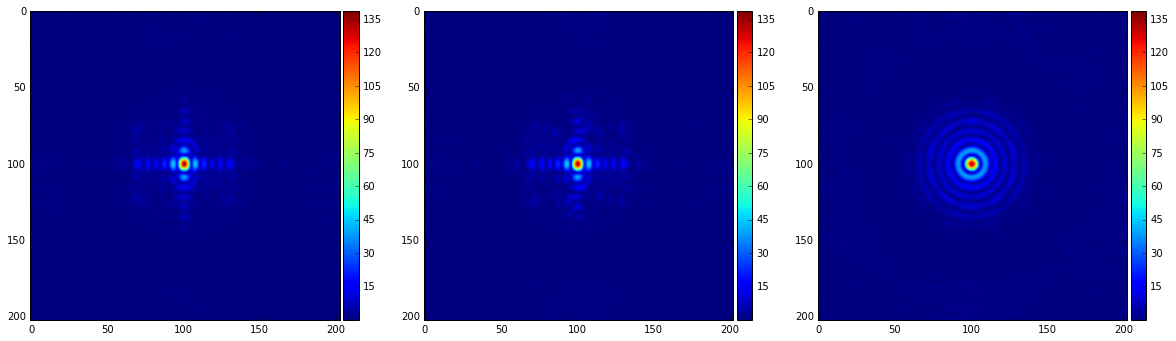

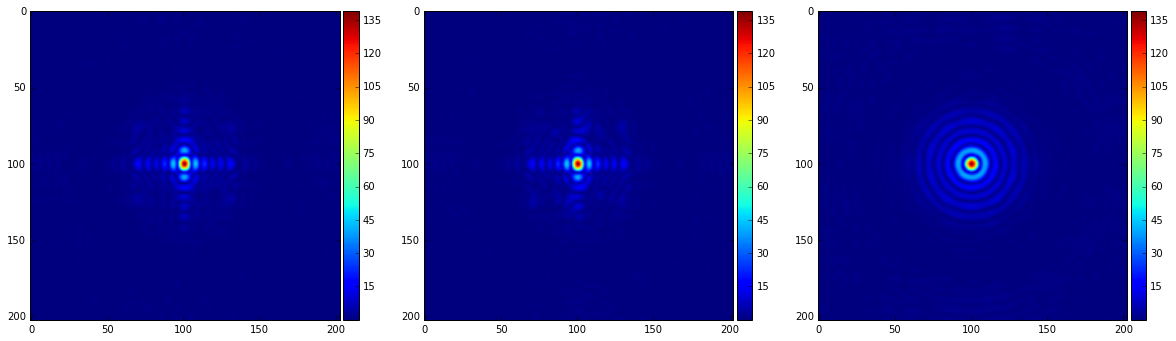

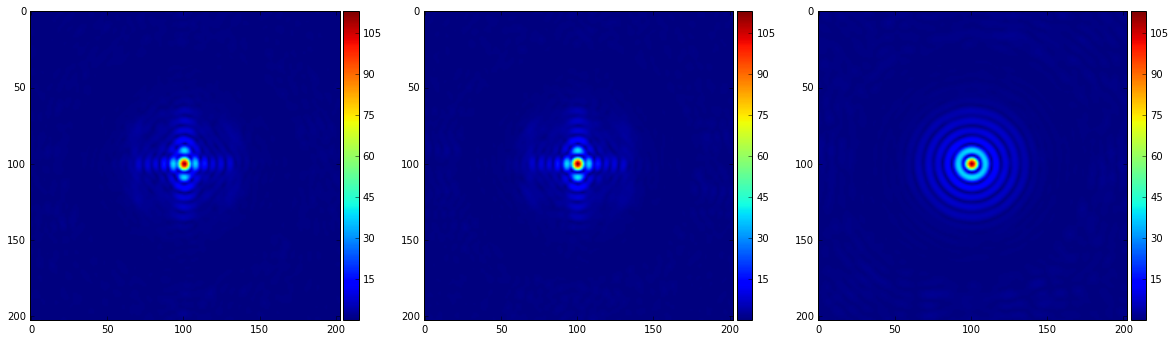

In [100]:
plot_3d_cuts(np.abs(vol_11k), logscale=False)
plot_3d_cuts(np.abs(vol_5k), logscale=False)
plot_3d_cuts(np.abs(vol_100), logscale=False)